In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
#from sklearnex import patch_sklearn
#patch_sklearn()
import pyro
import numpy as np
import pylab as pl
import pandas as pd
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pyro
from pyro import distributions as dist
from pyro.infer.mcmc import MCMC, HMC, NUTS
import seaborn as sns
import matplotlib.pyplot as plt
from pyro.infer import SVI, Trace_ELBO, Predictive

sns.set_style("whitegrid")

from scripts import *
from models import *

In [3]:
data = pd.read_csv("../Datasets/Avocado_prices_2020/avocado-updated-2020.csv", sep=",")

In [4]:
data.describe()

,average_price,total_volume,4046,4225,4770,total_bags,small_bags,large_bags,xlarge_bags,year
count,33045.000000,3.304500e+04,3.304500e+04,3.304500e+04,3.304500e+04,3.304500e+04,3.304500e+04,3.304500e+04,3.304500e+04,33045.000000
mean,1.379941,9.683997e+05,3.023914e+05,2.797693e+05,2.148255e+04,3.646735e+05,2.501980e+05,1.067329e+05,7.742585e+03,2017.460887
std,0.378972,3.934533e+06,1.301026e+06,1.151052e+06,1.001607e+05,1.564004e+06,1.037734e+06,5.167226e+05,4.819803e+04,1.699747
min,0.440000,8.456000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2015.000000
25%,1.100000,1.511895e+04,7.673100e+02,2.712470e+03,0.000000e+00,9.121860e+03,6.478630e+03,4.662900e+02,0.000000e+00,2016.000000
50%,1.350000,1.291170e+05,1.099477e+04,2.343600e+04,1.780900e+02,5.322224e+04,3.687699e+04,6.375860e+03,0.000000e+00,2017.000000
75%,1.620000,5.058285e+05,1.190219e+05,1.352389e+05,5.096530e+03,1.744314e+05,1.206624e+05,4.041723e+04,8.044400e+02,2019.000000
max,3.250000,6.371614e+07,2.274362e+07,2.047057e+07,2.546439e+06,3.168919e+07,2.055041e+07,1.332760e+07,1.403184e+06,2020.000000


In [5]:
# Check null values
data.isnull().sum()

date             0
average_price    0
total_volume     0
4046             0
4225             0
4770             0
total_bags       0
small_bags       0
large_bags       0
xlarge_bags      0
type             0
year             0
geography        0
dtype: int64

In [6]:
# Convert date to datetime format
data["date"] = pd.to_datetime(data["date"])

In [7]:
# Sort data by date
data = data.sort_values(["date"], ascending=[True]) 

In [8]:
# Consider data of the whole US
avocado_us = data[data["geography"]=="Total U.S."]

In [9]:
class avocado_colors():
    def __init__(self):
        # self.colors = ["#4a7337", "#6b8c21", "#704012"]
        # self.colors = ["#4a7337", "#d89465", "#704012"]
        self.colors = ["#4a7337", "#ffdb58", "#a44441"]
        self.i = -1

    def __getitem__(self, idx):
        return self.colors[idx]
    
    def __call__(self):
        self.i = (self.i + 1) % len(self.colors)
        return self.colors[self.i]

    def test_colors(self):
        for i in range(len(self.colors)):
            pl.plot(np.random.normal(0,1,1000).cumsum(), color=self.colors[i])

colors = avocado_colors()

def moving_average(x, w=21):
    return np.convolve(x, np.ones(w), 'same') / w

def plot_series(data, legend=None, w=1):
    i = 0
    for column in data:
        if column != "date":
            x = pd.to_datetime(data["date"])
            y = moving_average(data[column], w)
            label = column if legend is None else legend[i]
            pl.plot_date(x, y, "-", label=label, color=colors())
            i += 1
    pl.legend()
    pl.xlabel("Date")

def sum_columns(data, columns, name):
    data[name] = data[columns].sum(axis=1)


Text(0.5, 1.0, 'Avocados sold by type')

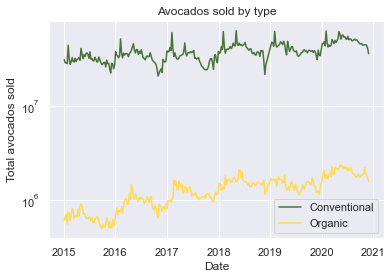

In [10]:
# Total avocados sold over time
plot_series(avocado_us[avocado_us["type"]=="conventional"][["date", "total_volume"]], legend=["Conventional"])
plot_series(avocado_us[avocado_us["type"]=="organic"][["date", "total_volume"]], legend=["Organic"])
pl.yscale("log")
pl.ylabel("Total avocados sold")
pl.title("Avocados sold by type")

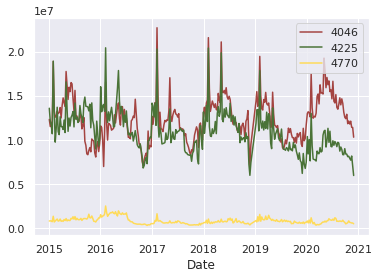

In [10]:
# Avocados sold by type over time
plot_series(avocado_us[avocado_us["type"]=="conventional"][["date", "4046", "4225", "4770"]])

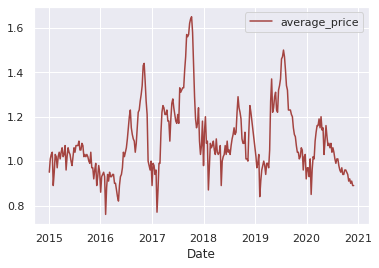

In [11]:
# Avocado price over time
plot_series(avocado_us[avocado_us["type"]=="conventional"][["date", "average_price"]])

It seems that the Avocadopocalypse of 2017 was indeed real, the price grew to over 1.6$, a 50% increase from its mean of 1.08$

In [12]:
# Region by avocado sales
avocados_growth = pd.DataFrame(columns = set(data["geography"]))

for column in avocados_growth:
    region = data[(data["geography"]==column) & (data["type"]=="conventional")]
    avocados_per_year = region.groupby(region["date"].dt.year)["total_volume"].mean().to_numpy()
    avocados_growth[column] = avocados_per_year[1:] / avocados_per_year[:-1]

avocados_growth["year"] = np.sort(list(set(data["year"])))[1:]
avocados_growth = avocados_growth.set_index("year")

Text(0.5, 1.0, 'Growth of avocado sales by year')

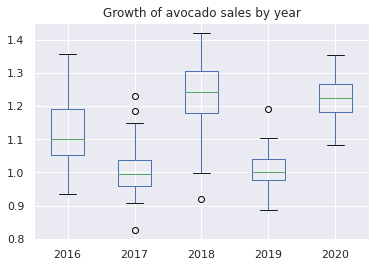

In [13]:
avocados_growth.T.plot.box()
pl.title("Growth of avocado sales by year")

## Gaussian process predictions

The power of the gaussian process is that it is highly customizable by choosing different kernels or sum of kernels, furthermore it provides confidence bounds on predictions and any length predictions

In [140]:
y = avocado_us[avocado_us["type"]=="conventional"][["total_volume"]].to_numpy()
x = np.arange(y.shape[0], dtype=float).reshape(-1, 1)

y *= 1e-7
x *= 1e-2

y_train, y_test = y[:-52], y[-52:]
x_train, x_test = x[:-52], x[-52:]

In [13]:
x_train, x_val = x_train[:-52], x_train[-52:]
y_train, y_val = y_train[:-52], y_train[-52:]

In [51]:
from skopt import gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Integer, Categorical
from IPython.display import clear_output

space  = [Real(1e-4, 1e4, "log-uniform", name='k1_constant'),
          Real(1e-4, 1e4, "log-uniform", name='k1_lengthscale'),
          Categorical([0.5, 1.5, 2.5, np.inf], name="k1_nu"),

          Real(1e-4, 1e4, "log-uniform", name='k2_constant'),
          Real(1e-4, 1e4, "log-uniform", name='k2_lengthscale'),
          Categorical([0.5, 1.5, 2.5, np.inf], name="k2_nu"),
          Real(1e-4, 1e4, "log-uniform", name='k2_sine_lengthscale'),

          Real(1e-4, 1e4, "log-uniform", name='k3_constant'),
          Real(1e-4, 1e4, "log-uniform", name='k3_lengthscale'),
          Real(1e-4, 1e4, "log-uniform", name='k3_alpha')]


def create_kernel(params):
    # General trend
    k1 = ConstantKernel(params["k1_constant"], "fixed") * Matern(params["k1_lengthscale"], "fixed", nu=params["k1_nu"])
    # Year seasonality
    k2 = ConstantKernel(params["k2_constant"], "fixed") * Matern(params["k2_lengthscale"], "fixed", nu=params["k2_nu"]) \
         * ExpSineSquared(params["k2_sine_lengthscale"], 52*1e-2, "fixed")
    # Mid term irregularities
    k3 = ConstantKernel(params["k3_constant"], "fixed") * RationalQuadratic(params["k3_lengthscale"], params["k3_alpha"], "fixed", "fixed")
    # Noise
    k4 = WhiteKernel()
    
    return k1 + k2 + k3 + k4

@use_named_args(space)
def objective(**params):
    clear_output(wait=True)

    kernel = create_kernel(params)

    model = GaussianProcessRegressor(kernel, n_restarts_optimizer=0, normalize_y=True).fit(x_train, y_train)
    return np.sum((model.predict(x_val) - y_val)**2)

res_gp = gp_minimize(objective, space, n_calls=50, acq_func="EI", verbose=True, n_jobs=-1)

/home/lettera/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 0.8836
Function value obtained: 38.6879
Current minimum: 15.8352


<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

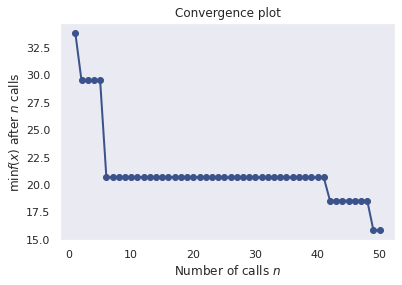

In [52]:
from skopt.plots import plot_convergence

plot_convergence(res_gp)

In [53]:
for var, value in zip(space, res_gp.x):
    print(var.name, ":", value)

k1_constant : 0.15803098468082946
k1_lengthscale : 34.87898275242443
k1_nu : 1.5
k2_constant : 492.6759223973092
k2_lengthscale : 0.2848575468936896
k2_nu : 1.5
k2_sine_lengthscale : 10000.0
k3_constant : 0.0058808740996523475
k3_lengthscale : 0.0008514736458023759
k3_alpha : 0.6943886806575332


In [49]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels \
    import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared, ConstantKernel, Matern, DotProduct, Exponentiation

# General trend
k1 = ConstantKernel(0.009847046470162862, "fixed") * Matern(1.3776056445974685, "fixed", nu=1.5)
# Year seasonality
k2 = ConstantKernel(17.515722223970137, "fixed") * Matern(24.49957258073102, "fixed", nu=2.5) * ExpSineSquared(2.0872063839876716, 52*1e-2, "fixed", "fixed")
# Mid term irregularities
k3 = ConstantKernel(1.2270786269373, "fixed") * RationalQuadratic(0.011692649823412426, 0.0013146815023358132, "fixed", "fixed")
# Noise
k4 = WhiteKernel()
kernel = k1+k2+k3+k4

model = GaussianProcessRegressor(kernel, n_restarts_optimizer=0, normalize_y=True).fit(x[:-52], y[:-52])

In [202]:
model.kernel_

0.585**2 * Matern(length_scale=1.02, nu=inf) + 0.779**2 * Matern(length_scale=1.79, nu=1.5) * ExpSineSquared(length_scale=0.307, periodicity=1.05) + 0.0319**2 * RationalQuadratic(alpha=16.4, length_scale=0.0001) + WhiteKernel(noise_level=0.3)

In [117]:
%matplotlib inline

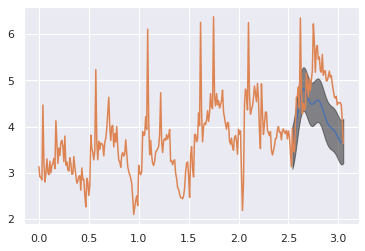

In [50]:
t = x_test[:, 0]

y_pred, y_std = model.predict(t.reshape(-1, 1), return_std=True)

y_pred = y_pred.ravel()

pl.fill_between(t, y_pred - y_std, y_pred + y_std, alpha=0.5, color='k')
pl.plot(t, y_pred)
pl.plot(x, y)

## Random forest

In [366]:
avocado.head()

,date,average_price,total_volume,4046,4225,4770,total_bags,small_bags,large_bags,xlarge_bags,type,year,geography
103,1.420330e+18,1.46,612910.15,233286.13,216611.20,4370.99,158641.83,115068.71,43573.12,0.0,organic,2015,Total U.S.
211,1.420934e+18,1.42,669528.88,270966.74,260971.60,3830.42,133760.12,106844.49,26915.63,0.0,organic,2015,Total U.S.
319,1.421539e+18,1.42,713120.00,254319.58,311811.01,4020.85,142968.56,101850.23,41118.33,0.0,organic,2015,Total U.S.
427,1.422144e+18,1.53,556368.86,207494.87,212312.02,4753.87,131808.10,95964.83,35843.27,0.0,organic,2015,Total U.S.
535,1.422749e+18,1.36,740896.97,302561.47,259286.44,5852.28,173196.78,129953.15,43243.63,0.0,organic,2015,Total U.S.


In [362]:
avocado = avocado.drop('geography', 1)
avocado['date'] = avocado['date'].values.astype('float64')

avocado = avocado_us[avocado_us['type']== 'organic']
# avocado = avocado_us[avocado_us['type']== 'conventional']

# x = avocado.drop(['average_price', 'type'], 1)
# y = avocado['average_price'].to_numpy()

x = avocado.drop(['total_volume', 'type'], 1)
y = avocado['total_volume'].to_numpy()

# one week prediction
y_train, y_test = y[:-1], y[-1:]
x_train, x_test = x[:-1], x[-1:]

n_features = x_train.shape[1]

<ipython-input-362-9c898f5a9a0e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avocado['date'] = avocado['date'].values.astype('float64')


In [363]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error


rf = RandomForestRegressor(n_estimators=10000, n_jobs=-1, bootstrap=True, random_state=0)
rf.fit(x_train, y_train.ravel())
yhat = rf.predict(x_test)

print('MSE:', mean_absolute_error(y_test, yhat))

MSE: 0.0175320000000585


In [364]:
importances = list(rf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(x.columns, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: date                 Importance: 0.22
Variable: total_volume         Importance: 0.19
Variable: small_bags           Importance: 0.14
Variable: large_bags           Importance: 0.1
Variable: 4225                 Importance: 0.09
Variable: 4046                 Importance: 0.08
Variable: 4770                 Importance: 0.08
Variable: total_bags           Importance: 0.07
Variable: xlarge_bags          Importance: 0.02
Variable: year                 Importance: 0.01


[None, None, None, None, None, None, None, None, None, None]

In [365]:
rf = RandomForestRegressor(n_estimators=10000, n_jobs=-1, bootstrap=True, random_state=0)

space  = [# Categorical(['True', 'False'], name = 'bootstrap'),
          #Integer(10, 5000, name= 'n_estimators'),
          Integer(1, 30, name= 'max_depth'),
          Integer(1, n_features, name= 'max_features'),
          Integer(2, 100, name= 'min_samples_split'), # default 2
          Integer(1, 100, name= 'min_samples_leaf')] # default 1

@use_named_args(dimensions= space)
def objective(**params):
    rf.set_params(**params)
    rf.fit(x_train, y_train.ravel())
    yhat = rf.predict(x_test)
    return np.mean(mean_absolute_error(y_test, yhat))

res_gp = gp_minimize(objective, space, acq_func="LCB", n_calls=50, verbose=True, random_state = 0)

# kappa high: favouring exploration over exploitation. Default 2.6

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 7.5984
Function value obtained: 0.1491
Current minimum: 0.1491
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 8.2581
Function value obtained: 0.0390
Current minimum: 0.0390
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 7.7200
Function value obtained: 0.0882
Current minimum: 0.0390
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 7.5330
Function value obtained: 0.1444
Current minimum: 0.0390
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 7.4381
Function value obtained: 0.1502
Current minimum: 0.0390
Iteration No: 6 started. Evaluating

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

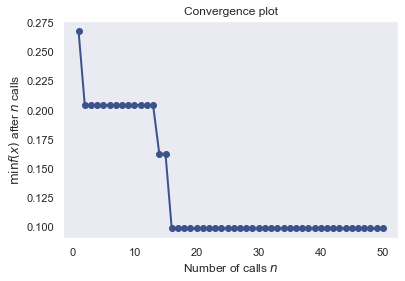

In [359]:
from skopt.plots import plot_convergence

plot_convergence(res_gp)

In [360]:
print("""Best parameters:
- max_depth=%d
- max_features=%d
- min_samples_split=%d
- min_samples_leaf=%d""" % (res_gp.x[0], res_gp.x[1], res_gp.x[2], res_gp.x[3]))


Best parameters:
- max_depth=19
- max_features=10
- min_samples_split=2
- min_samples_leaf=1


In [361]:
rf_opt = RandomForestRegressor(n_estimators=10000, n_jobs=-1, bootstrap=True, max_depth= 19, max_features = 10, min_samples_split=2, min_samples_leaf=1, random_state=0)
rf_opt.fit(x_train, y_train.ravel())
yhat = rf_opt.predict(x_test)

print('MSE:', mean_absolute_error(y_test, yhat))

MSE: 0.0985090000000648


In [218]:
importances = list(rf_opt.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(x.columns, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: total_bags           Importance: 0.11
Variable: large_bags           Importance: 0.11
Variable: date                 Importance: 0.1
Variable: total_volume         Importance: 0.1
Variable: 4046                 Importance: 0.1
Variable: 4225                 Importance: 0.1
Variable: small_bags           Importance: 0.1
Variable: year                 Importance: 0.1
Variable: 4770                 Importance: 0.09
Variable: xlarge_bags          Importance: 0.09


[None, None, None, None, None, None, None, None, None, None]

## XGB BOOST

In [337]:
gbr = GradientBoostingRegressor(random_state=0)
gbr.fit(x_train, y_train.ravel())
yhat = gbr.predict(x_test)

print('MSE:', mean_absolute_error(y_test, yhat))

MSE: 0.0348327729497534


In [338]:
from sklearn.ensemble import GradientBoostingRegressor

space  = [Integer(30, 3000, name= 'n_estimators'),
          Integer(1, 250, name='max_depth'),
          Real(10**-5, 10**0, "log-uniform", name='learning_rate'),
          Integer(1, n_features, name='max_features'),
          Integer(2, 150, name='min_samples_split'),
          Integer(1, 100, name='min_samples_leaf')]

@use_named_args(space)
def objective(**params):
    gbr.set_params(**params)
    gbr.fit(x_train, y_train.ravel())
    yhat = gbr.predict(x_test)
    return mean_absolute_error(y_test, yhat)

res_gp = gp_minimize(objective, space, acq_func="LCB", n_calls=70, verbose=True)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.2629
Function value obtained: 0.2215
Current minimum: 0.2215
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0870
Function value obtained: 0.1600
Current minimum: 0.1600
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.2040
Function value obtained: 0.2032
Current minimum: 0.1600
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.7584
Function value obtained: 0.1793
Current minimum: 0.1600
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.5595
Function value obtained: 0.1606
Current minimum: 0.1600
Iteration No: 6 started. Evaluating

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

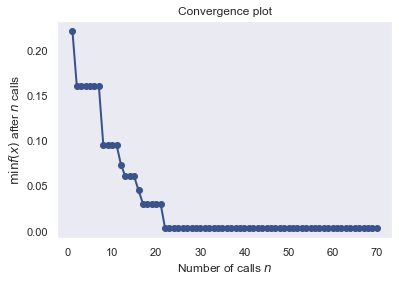

In [339]:
plot_convergence(res_gp)

In [340]:
 print("""Best parameters:
- n_estimators= %d
- max_depth=%d
- learning_rate=%.6f
- max_features = %d
- min_samples_split=%d
- min_samples_leaf=%d""" % (res_gp.x[0], res_gp.x[1], res_gp.x[2], res_gp.x[3], res_gp.x[4], res_gp.x[5]))


Best parameters:
- n_estimators= 3000
- max_depth=109
- learning_rate=1.000000
- max_features = 8
- min_samples_split=144
- min_samples_leaf=1


In [341]:
gbr_opt = GradientBoostingRegressor(n_estimators=3000, max_depth=109, learning_rate= 1., 
                                    max_features= 8, min_samples_split=144, min_samples_leaf=1, random_state=0)
gbr_opt.fit(x_train, y_train.ravel())
yhat = gbr_opt.predict(x_test)

print('MSE:', mean_absolute_error(y_test, yhat))

MSE: 0.0032992569203602606


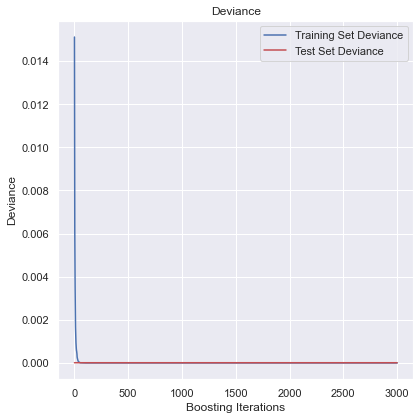

In [342]:
# not useful? found online

test_score = np.zeros((gbr_opt.n_estimators), dtype=np.float64)
for i, y_pred in enumerate(gbr_opt.staged_predict(x_test)):
    test_score[i] = gbr_opt.loss_(y_test, yhat)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(gbr_opt.n_estimators) + 1, gbr_opt.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(gbr_opt.n_estimators) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()

/Users/ireneferfoglia/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


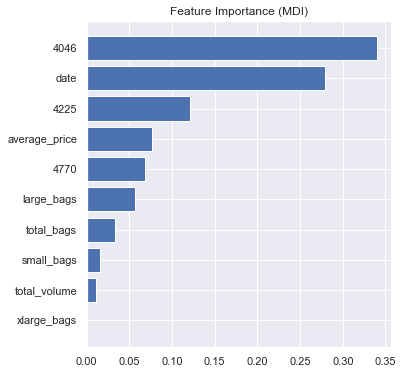

In [343]:
from sklearn.inspection import permutation_importance

feature_importance = gbr_opt.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(avocado_us.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')

result = permutation_importance(gbr_opt, x_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

plt.show()